<div>
    <img src="https://i.imgur.com/QrL4fIn.png">
</div>

# Introduction 📗

> 🎯Goal: To predict the amount of an insurance claim

> Tabular Playground Series entails synthetic data based on real data, which revolves around predicting the amount of an insurance claim. The competition data is generated using CTGAN.

> - [Competition data](https://www.kaggle.com/c/tabular-playground-series-mar-2021/data)
> - [Competition notebook](https://www.kaggle.com/ruchi798/tps-march-2021-eda-rapids) 

# 1. Importing libraries 📚

In [2]:
!pip install pycomp

import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import time
import cudf
import cuml
import xgboost
import shap

from random import randint
from pycomp.viz.insights import *
from cuml.linear_model import Ridge
from cuml.svm import SVR
from cuml.neighbors import KNeighborsClassifier
from cuml.metrics import accuracy_score,roc_auc_score as ras
from cuml.preprocessing.model_selection import train_test_split
from cuml.preprocessing.TargetEncoder import TargetEncoder

     |████████████████████████████████| 52 kB 427 kB/s 
     |████████████████████████████████| 215 kB 1.1 MB/s 
     |████████████████████████████████| 294 kB 3.9 MB/s 
     |████████████████████████████████| 12.4 MB 1.9 MB/s 
     |████████████████████████████████| 326 kB 2.4 MB/s 
     |████████████████████████████████| 6.8 MB 2.2 MB/s 
     |████████████████████████████████| 20.1 MB 2.2 MB/s 
  Created wheel for shap: filename=shap-0.37.0-cp37-cp37m-linux_x86_64.whl size=468630 sha256=a744b2fcfae4139557a641e1e4513902680ac68bfa1aed8e458eb72948253c39
  Stored in directory: /root/.cache/pip/wheels/df/b8/18/2c0a6105152e62dd9a7cf47b5110b9cedb0c8739babdef64b7
Successfully built shap
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: joblib
    Found existing installation: joblib 1.0.0
    Uninstalling joblib-1.0.0:
      Successfully uninstalled joblib-1.0.0
  Attem

In [3]:
!nvidia-smi

Sun Mar 21 17:49:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    33W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Wed_Oct_23_19:24:38_PDT_2019
Cuda compilation tools, release 10.2, V10.2.89


In [5]:
def custom_palette(custom_colors):
    customPalette = sns.set_palette(sns.color_palette(custom_colors))
    sns.palplot(sns.color_palette(custom_colors),size=0.8)
    plt.tick_params(axis='both', labelsize=0, length = 0)

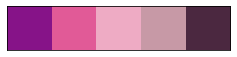

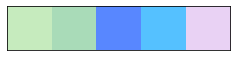

In [6]:
pink = ["#861388","#E15A97","#EEABC4","#C799A6","#4B2840"]
blue = ["#C6EBBE","#A9DBB8","#5887FF","#55C1FF","#E9D2F4"]
custom_palette(pink)
custom_palette(blue)

In [7]:
train_df = cudf.read_csv('../input/tabular-playground-series-mar-2021/train.csv', index_col='id')
train_df.head()

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,target
id,,,,,,,,,,,,,,,,,,,,,
0,A,I,A,B,B,BI,A,S,Q,A,...,0.759439,0.795549,0.681917,0.621672,0.592184,0.791921,0.815254,0.965006,0.665915,0
1,A,I,A,A,E,BI,K,W,AD,F,...,0.386385,0.541366,0.388982,0.357778,0.600044,0.408701,0.399353,0.927406,0.493729,0
2,A,K,A,A,E,BI,A,E,BM,L,...,0.343255,0.616352,0.793687,0.552877,0.352113,0.388835,0.412303,0.292696,0.549452,0
3,A,K,A,C,E,BI,A,Y,AD,F,...,0.831147,0.807807,0.800032,0.619147,0.221789,0.897617,0.633669,0.760318,0.934242,0
4,A,I,G,B,E,BI,C,G,Q,A,...,0.338818,0.277308,0.610578,0.128291,0.578764,0.279167,0.351103,0.357084,0.328960,1


In [8]:
test_df = cudf.read_csv('../input/tabular-playground-series-mar-2021/test.csv', index_col='id')
test_df.head()

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10
id,,,,,,,,,,,,,,,,,,,,,
5,A,F,A,A,F,BI,A,AH,AX,A,...,0.735690,0.578366,0.723154,0.228037,0.356227,0.551249,0.655693,0.598331,0.359987,0.947489
6,A,H,C,A,E,AB,I,F,N,A,...,0.313703,0.928885,0.516602,0.600169,0.795224,0.248987,0.654614,0.347944,0.565520,0.388580
8,A,N,C,A,F,AB,A,AH,BC,A,...,0.448201,0.424876,0.344729,0.242073,0.270632,0.746740,0.335590,0.341238,0.252289,0.411592
9,B,L,C,A,F,BI,A,E,AX,A,...,0.666092,0.598943,0.561971,0.806347,0.735983,0.538724,0.381566,0.481660,0.348514,0.325723
11,A,F,A,B,F,BI,A,AH,I,A,...,0.772229,0.479572,0.767745,0.252454,0.354810,0.178920,0.763479,0.562491,0.466261,0.585781


# 2. EDA 📊

In [9]:
train_p = train_df.to_pandas()
test_p = train_df.to_pandas()

dt_i=[]
dt_fl=[]
dt_o=[]

for col in train_p.columns:
    x=train_p[col].dtype
    if x=='int64':
        dt_i.append(col)
    elif x=='float64':
        dt_fl.append(col)
    else:
        dt_o.append(col)

In [10]:
print(dt_i)

['target']


In [11]:
print(dt_fl)

['cont0', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10']


In [12]:
print(dt_o)

['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14', 'cat15', 'cat16', 'cat17', 'cat18']


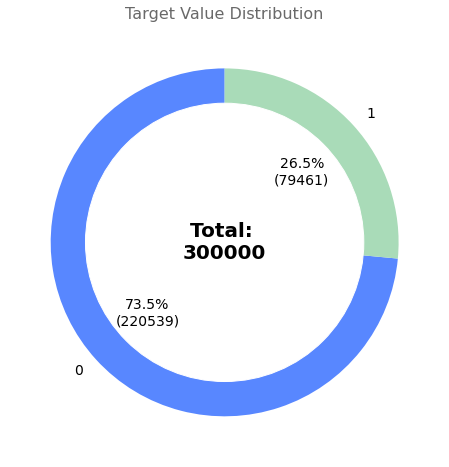

In [13]:
plot_donut_chart(df=train_p, col='target',
                 title='Target Value Distribution',colors=[blue[2],blue[1]])

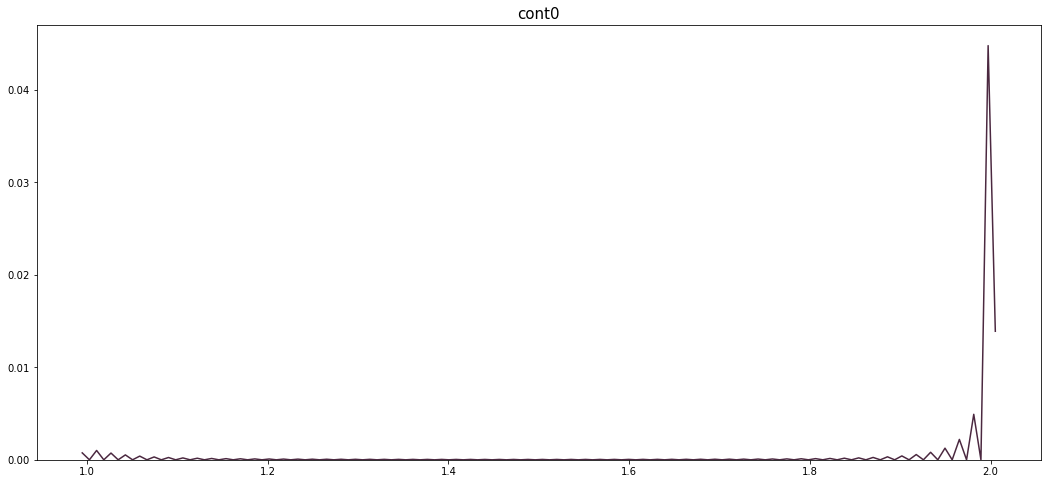

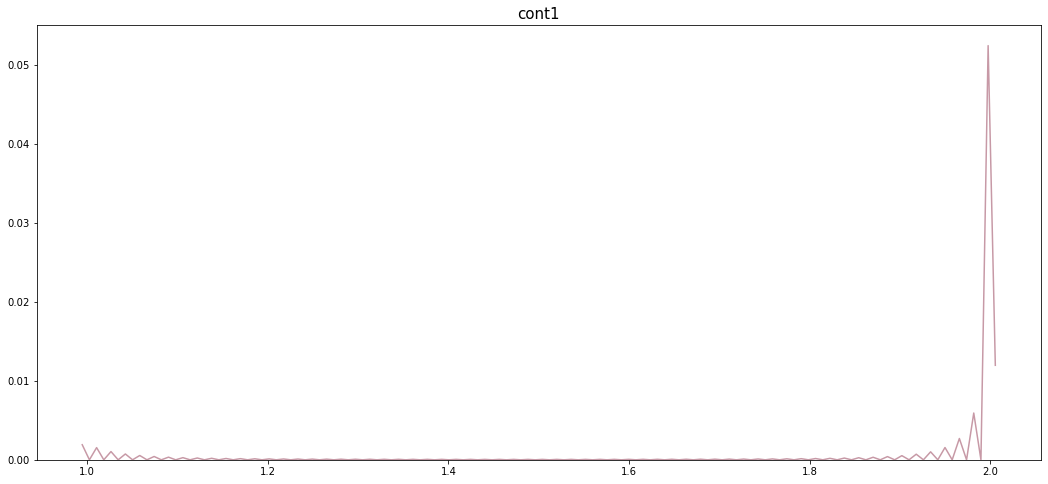

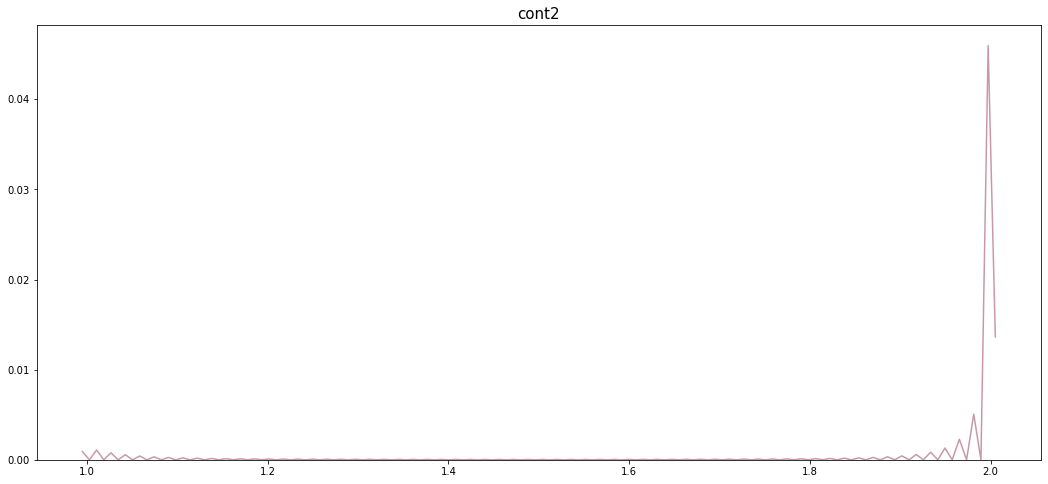

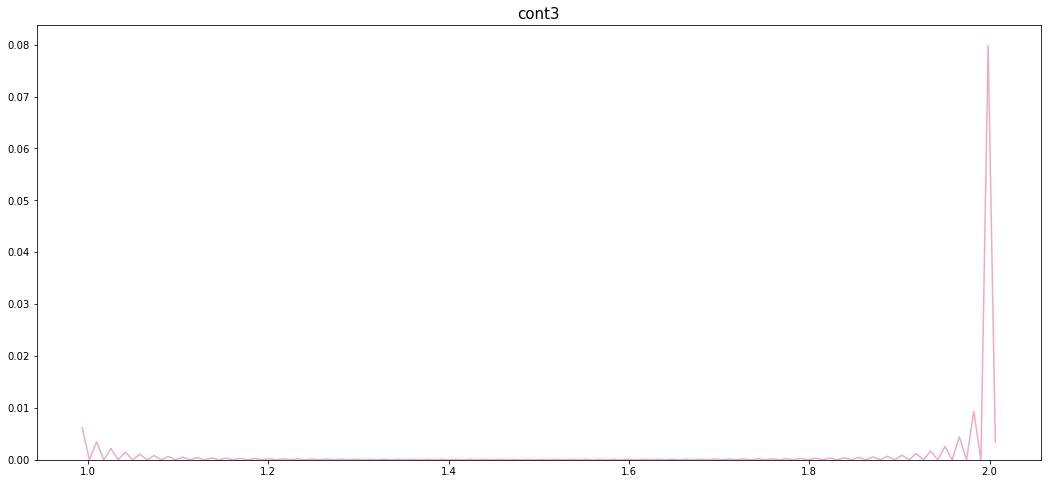

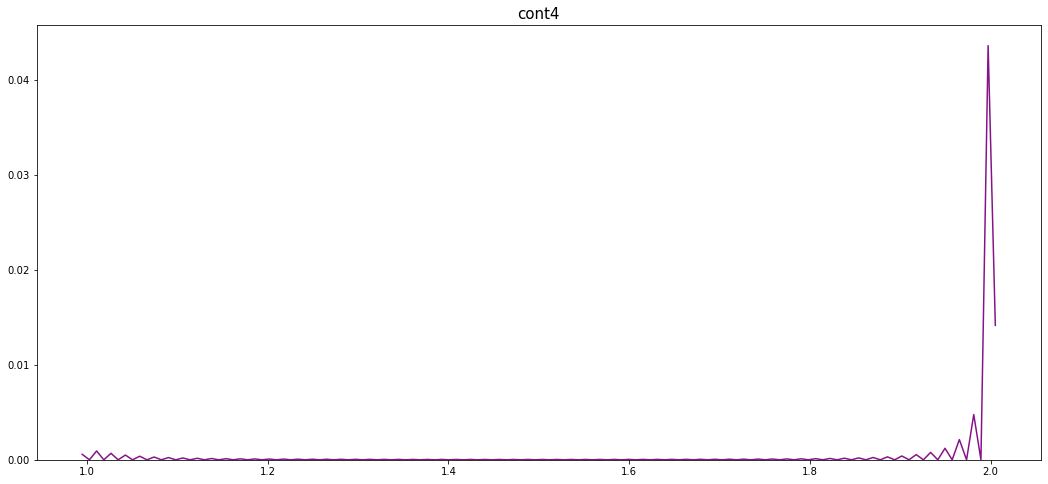

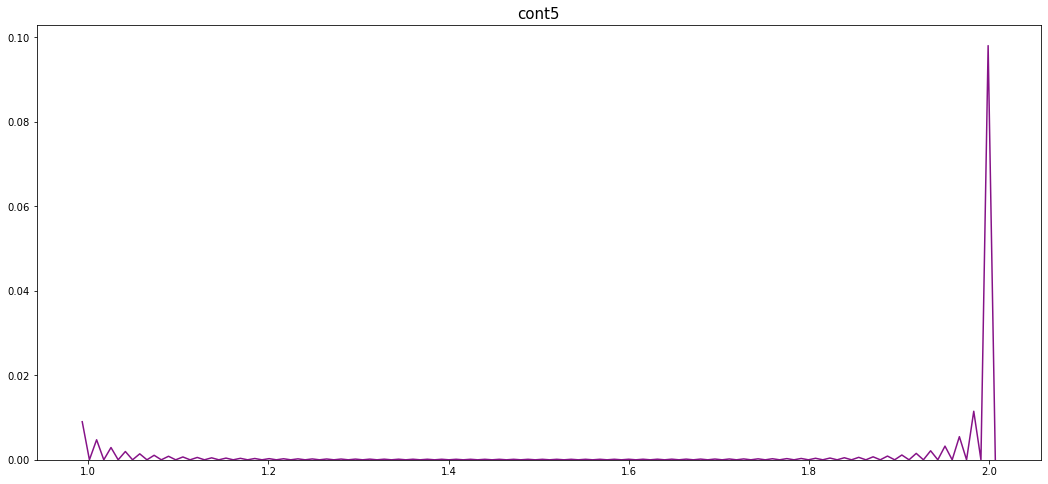

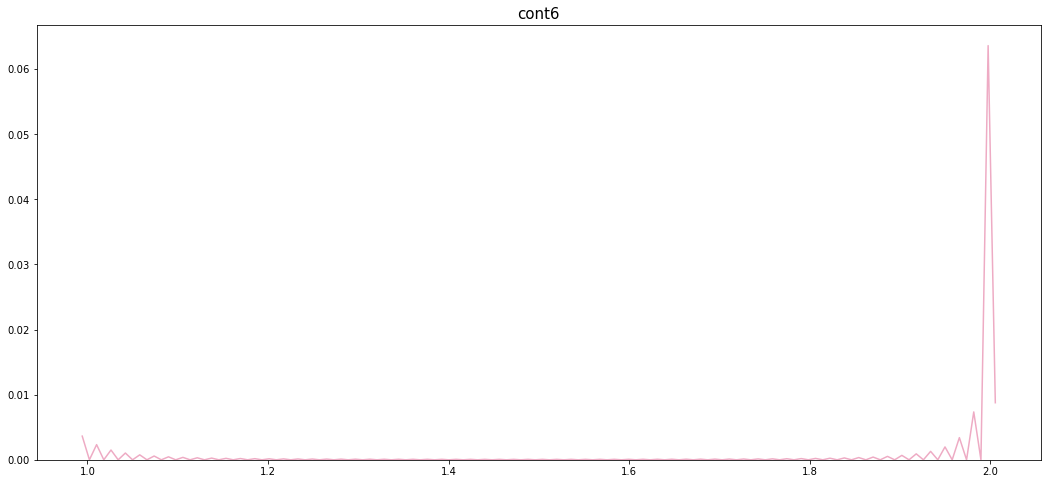

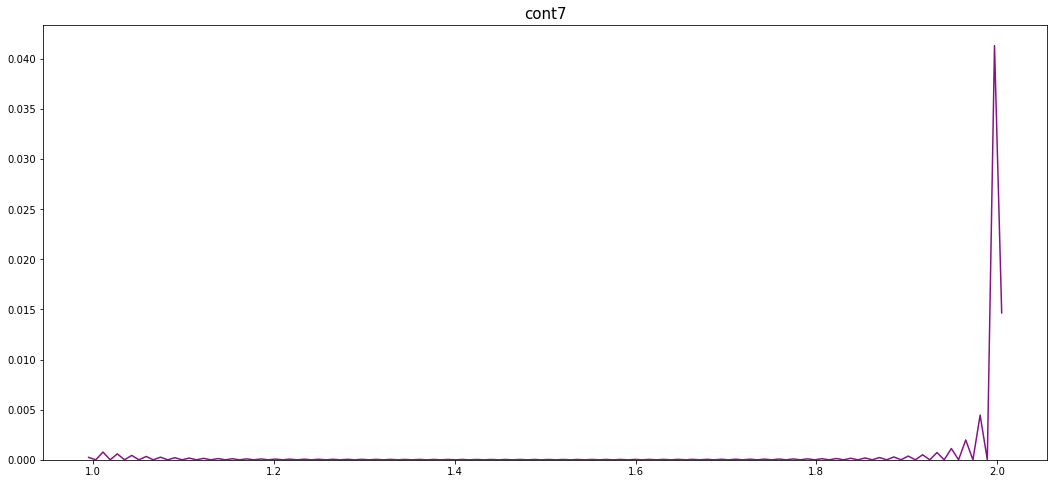

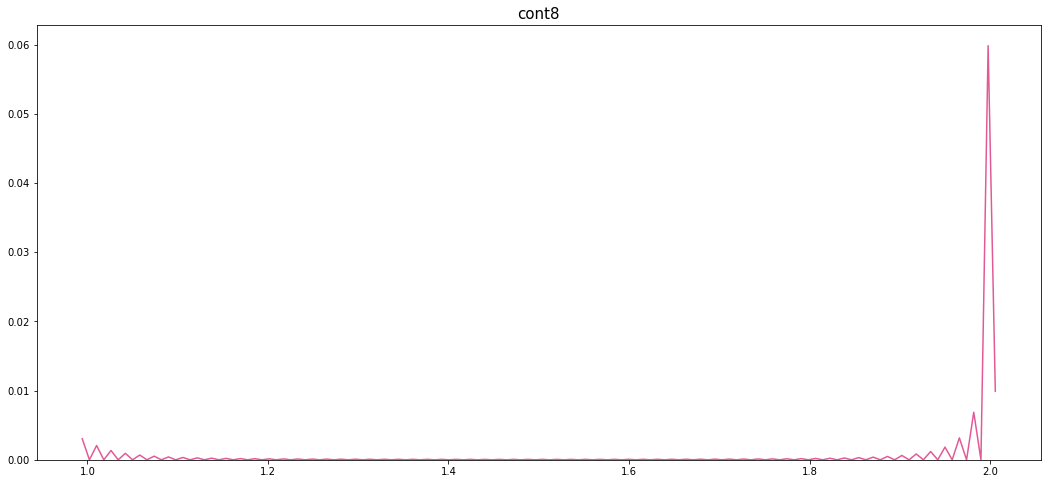

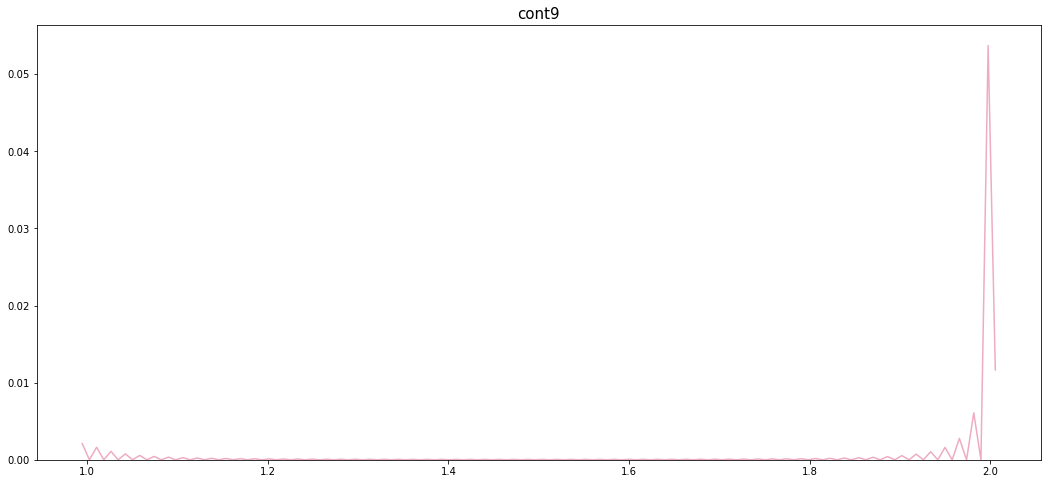

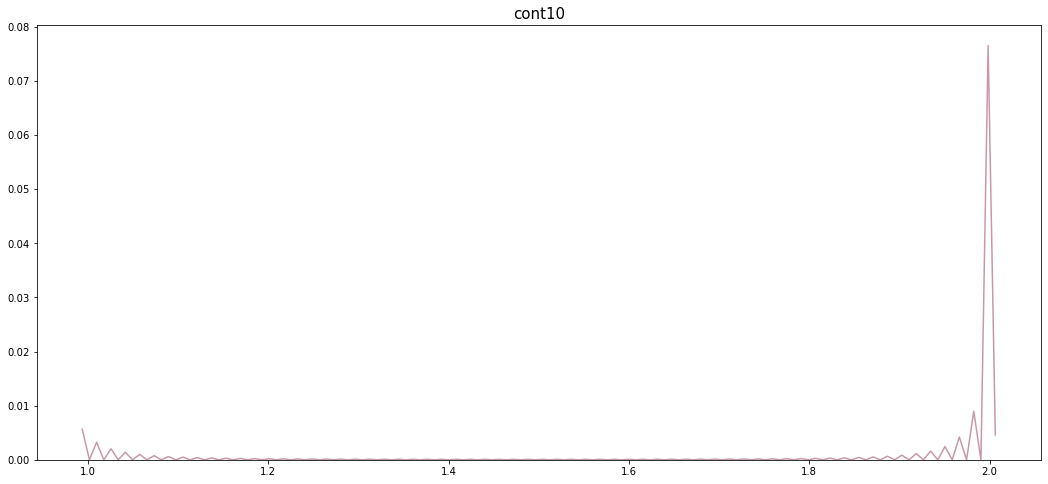

In [14]:
def plot_cont(values,title,c):
    plt.figure(figsize = (18, 8))
    sns.kdeplot(values, color = pink[c])
    plt.title(title, fontsize=15)
    plt.show();

for i in dt_fl:
    c = randint(0, 4)
    values = train_p[i].value_counts().reset_index()[i].values
    plot_cont(values,i,c)

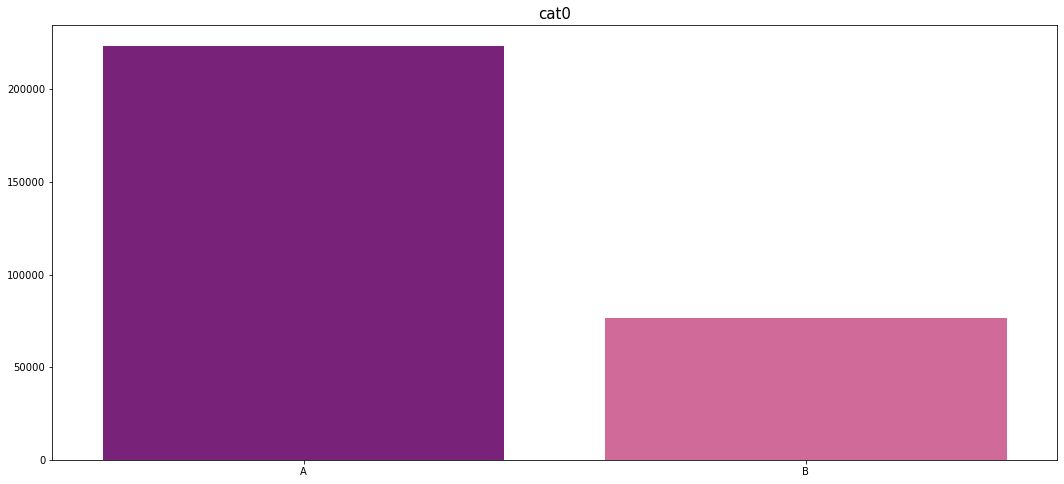

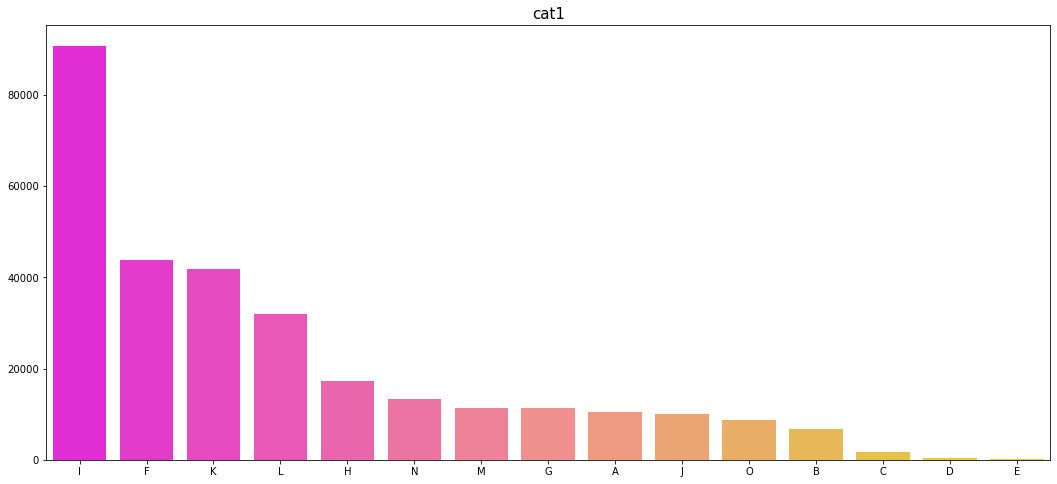

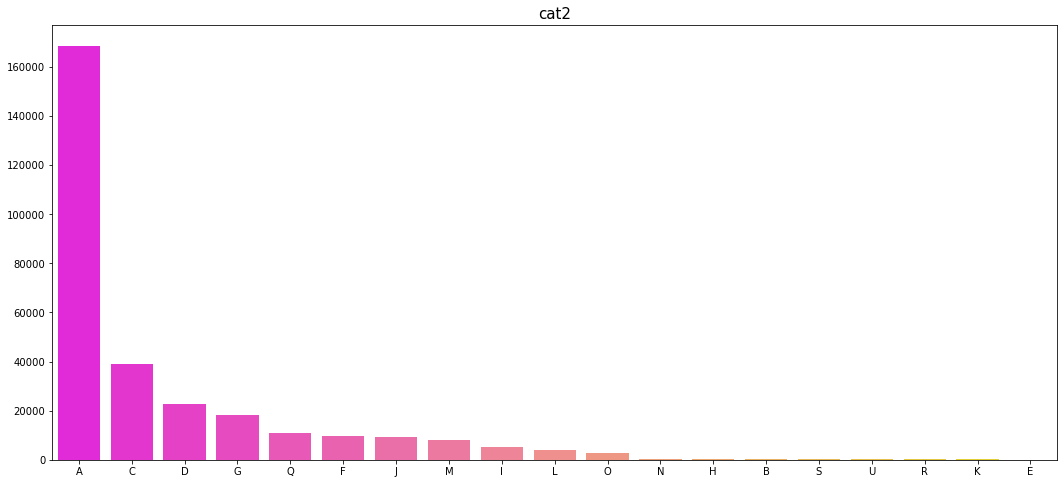

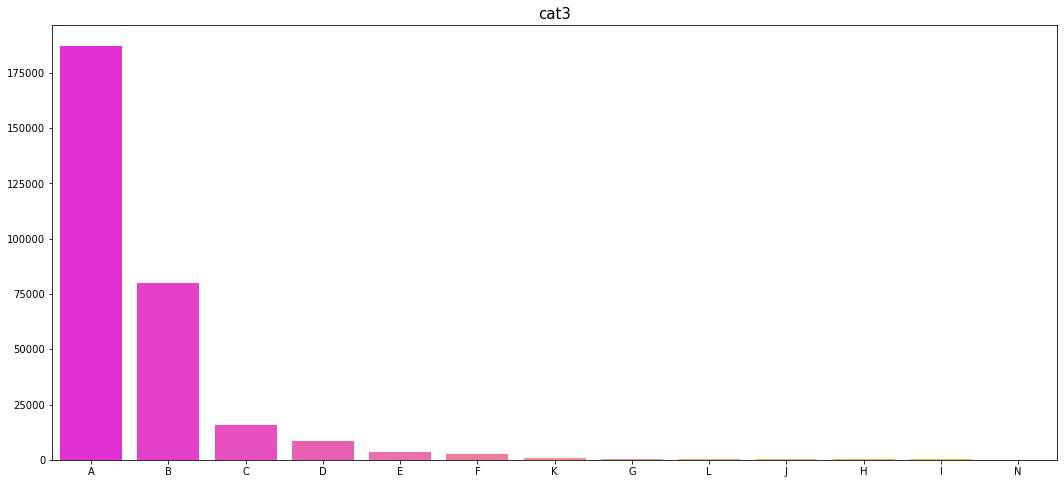

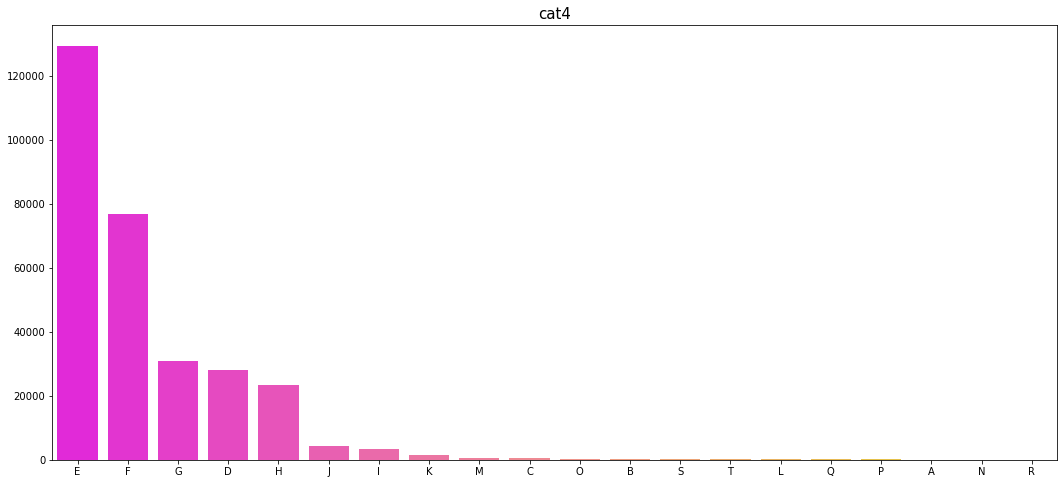

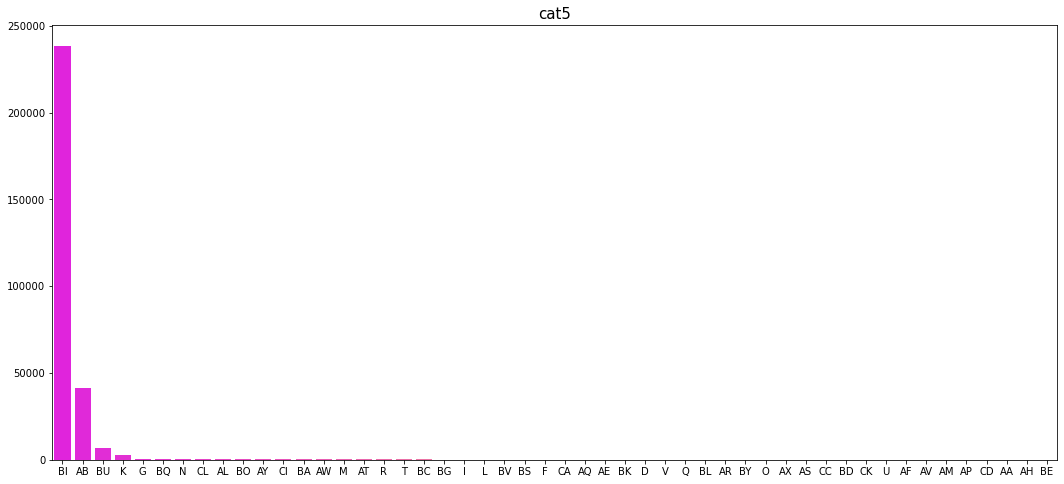

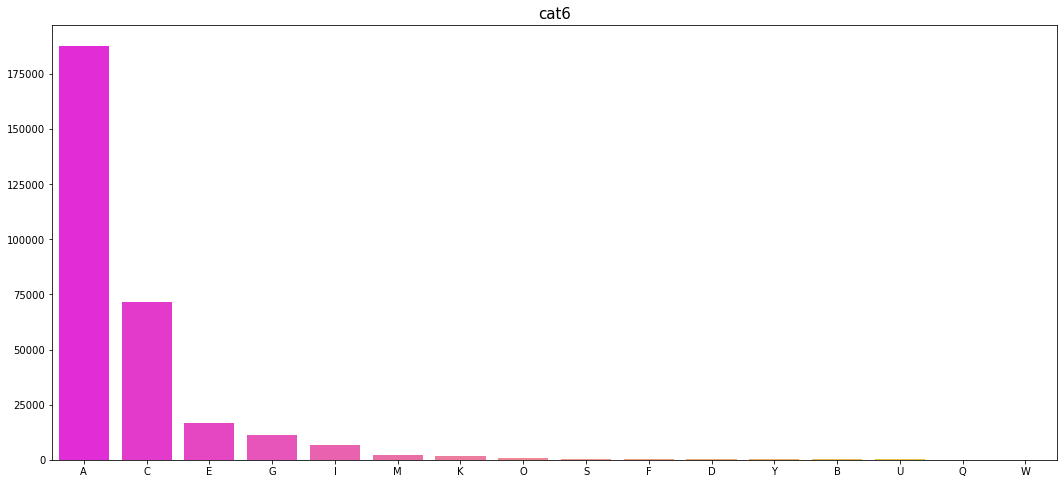

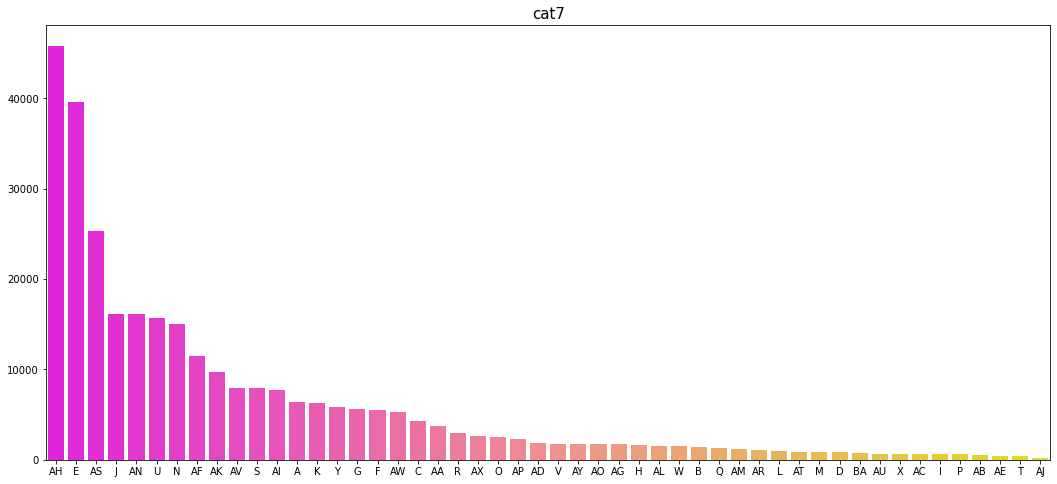

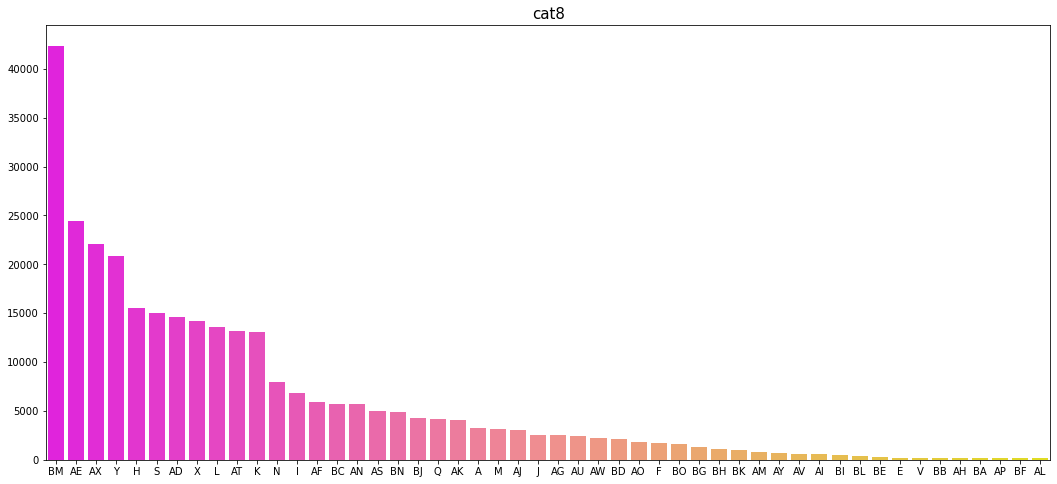

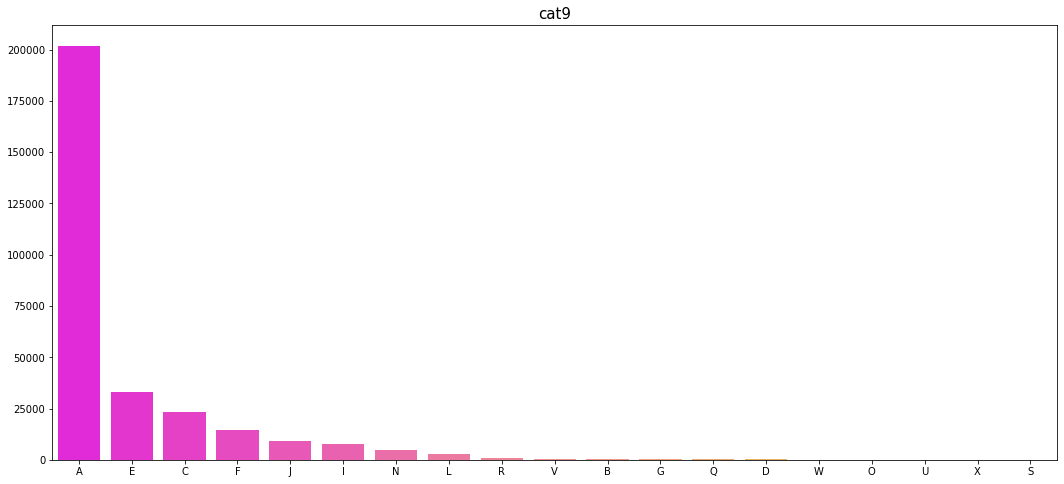

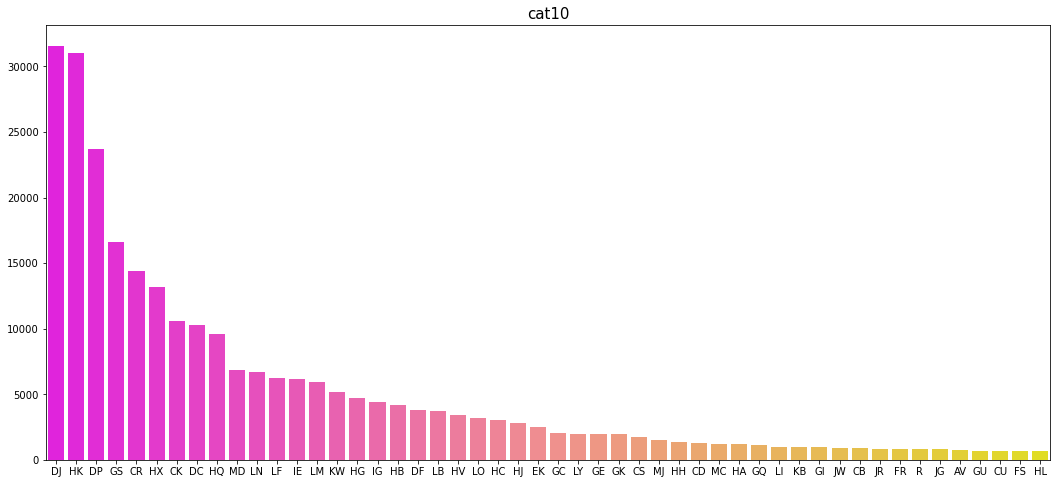

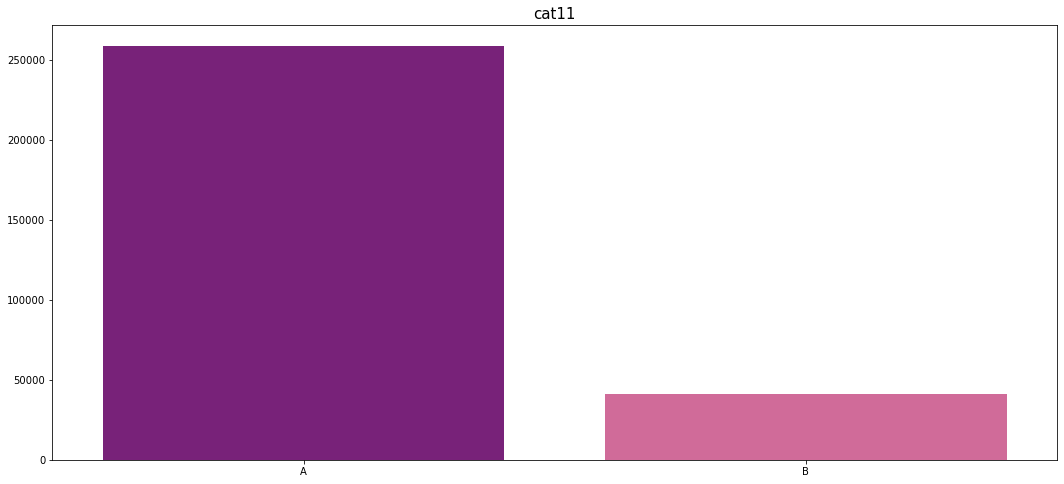

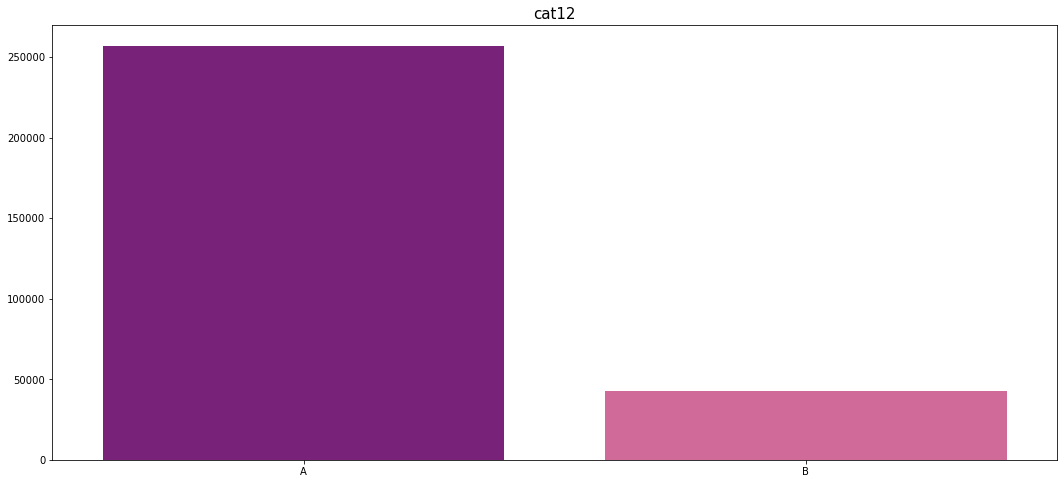

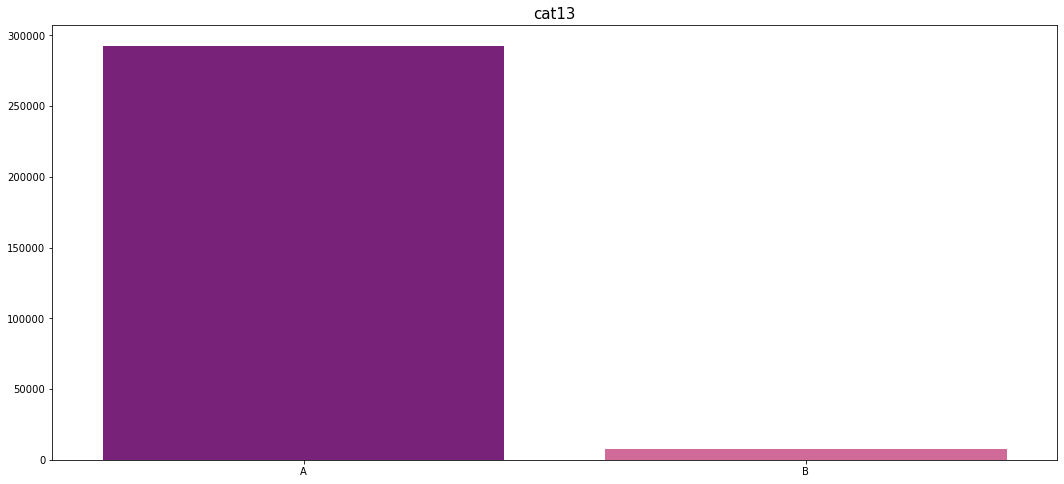

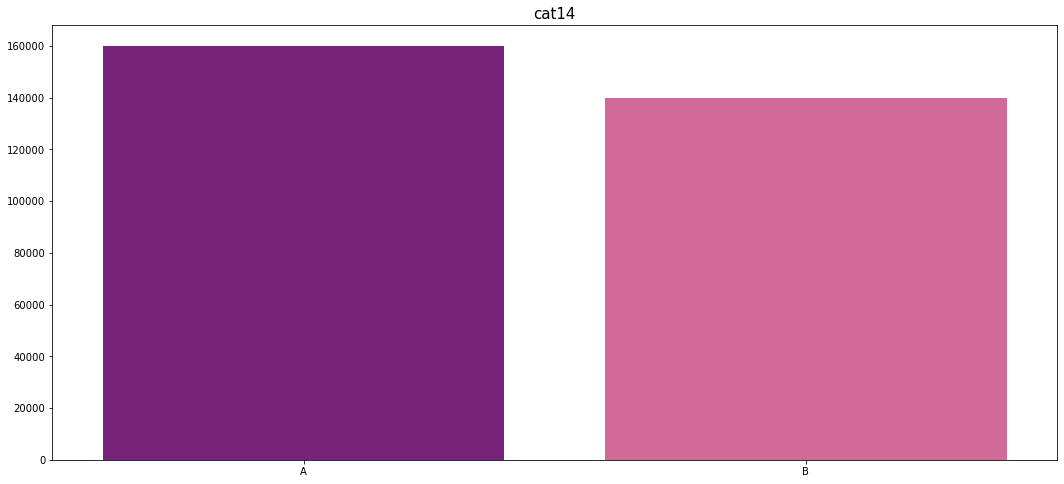

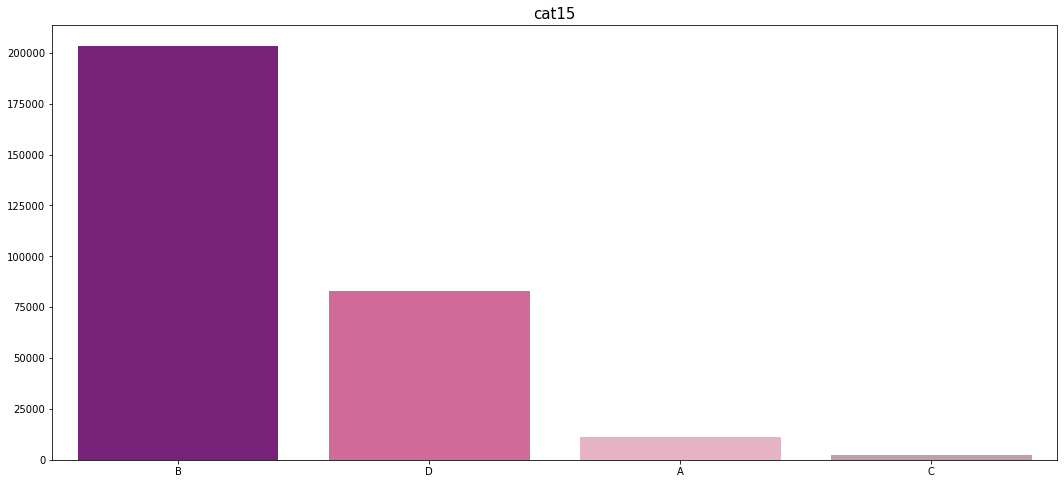

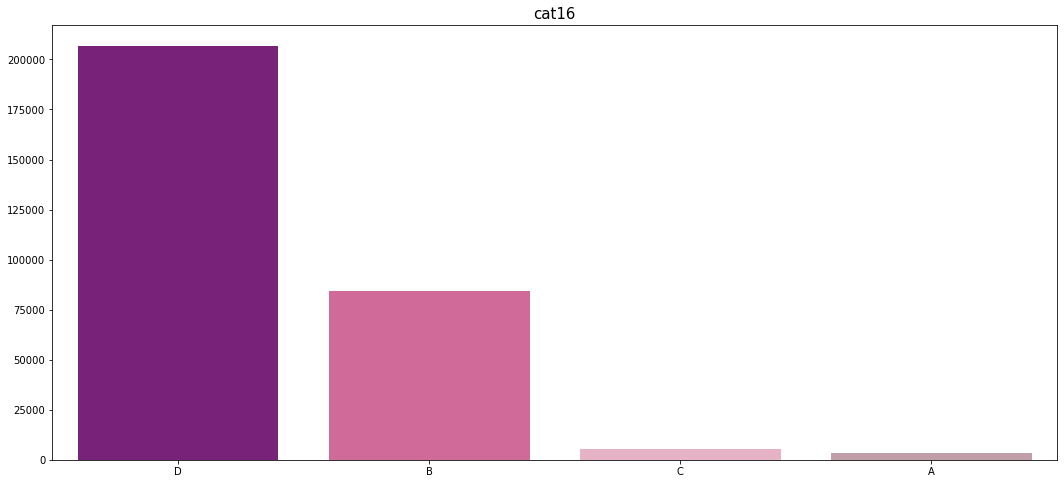

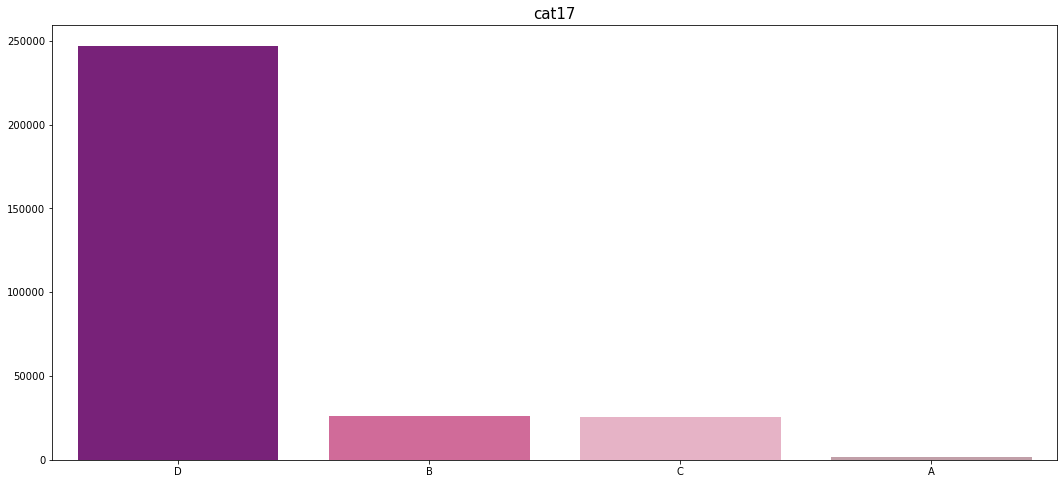

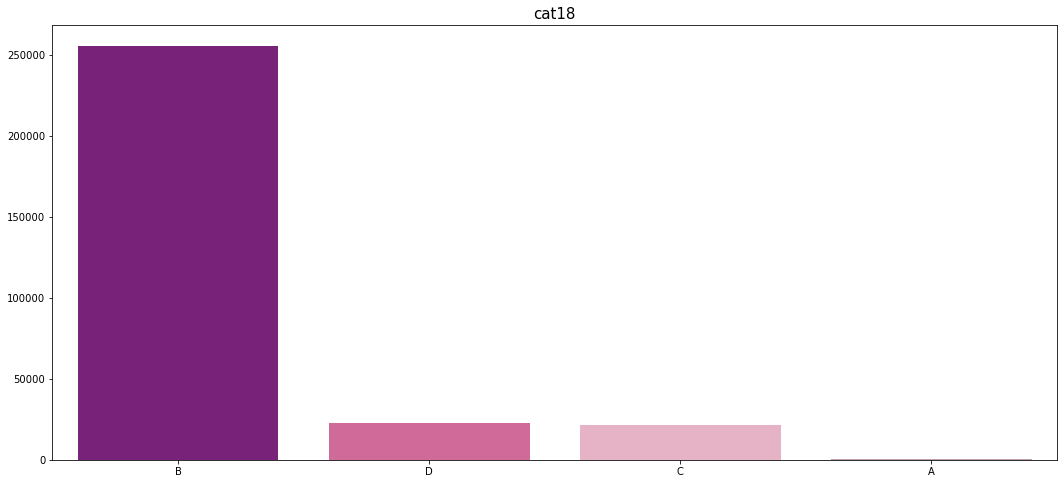

In [15]:
def plot_cat(index,values,title):
    if len(values)>10:
        p="spring"
        index=index[:50]
        values = values[:50]
    else:
        p=pink
        
    plt.figure(figsize = (18, 8))
    sns.barplot(x = index, y = values,palette=p)
    plt.title(title, fontsize=15)
    plt.show();
    
for i in dt_o:
    index = train_p[i].value_counts().reset_index()["index"].values
    values = train_p[i].value_counts().reset_index()[i].values
    plot_cat(index,values,i)

Correlation

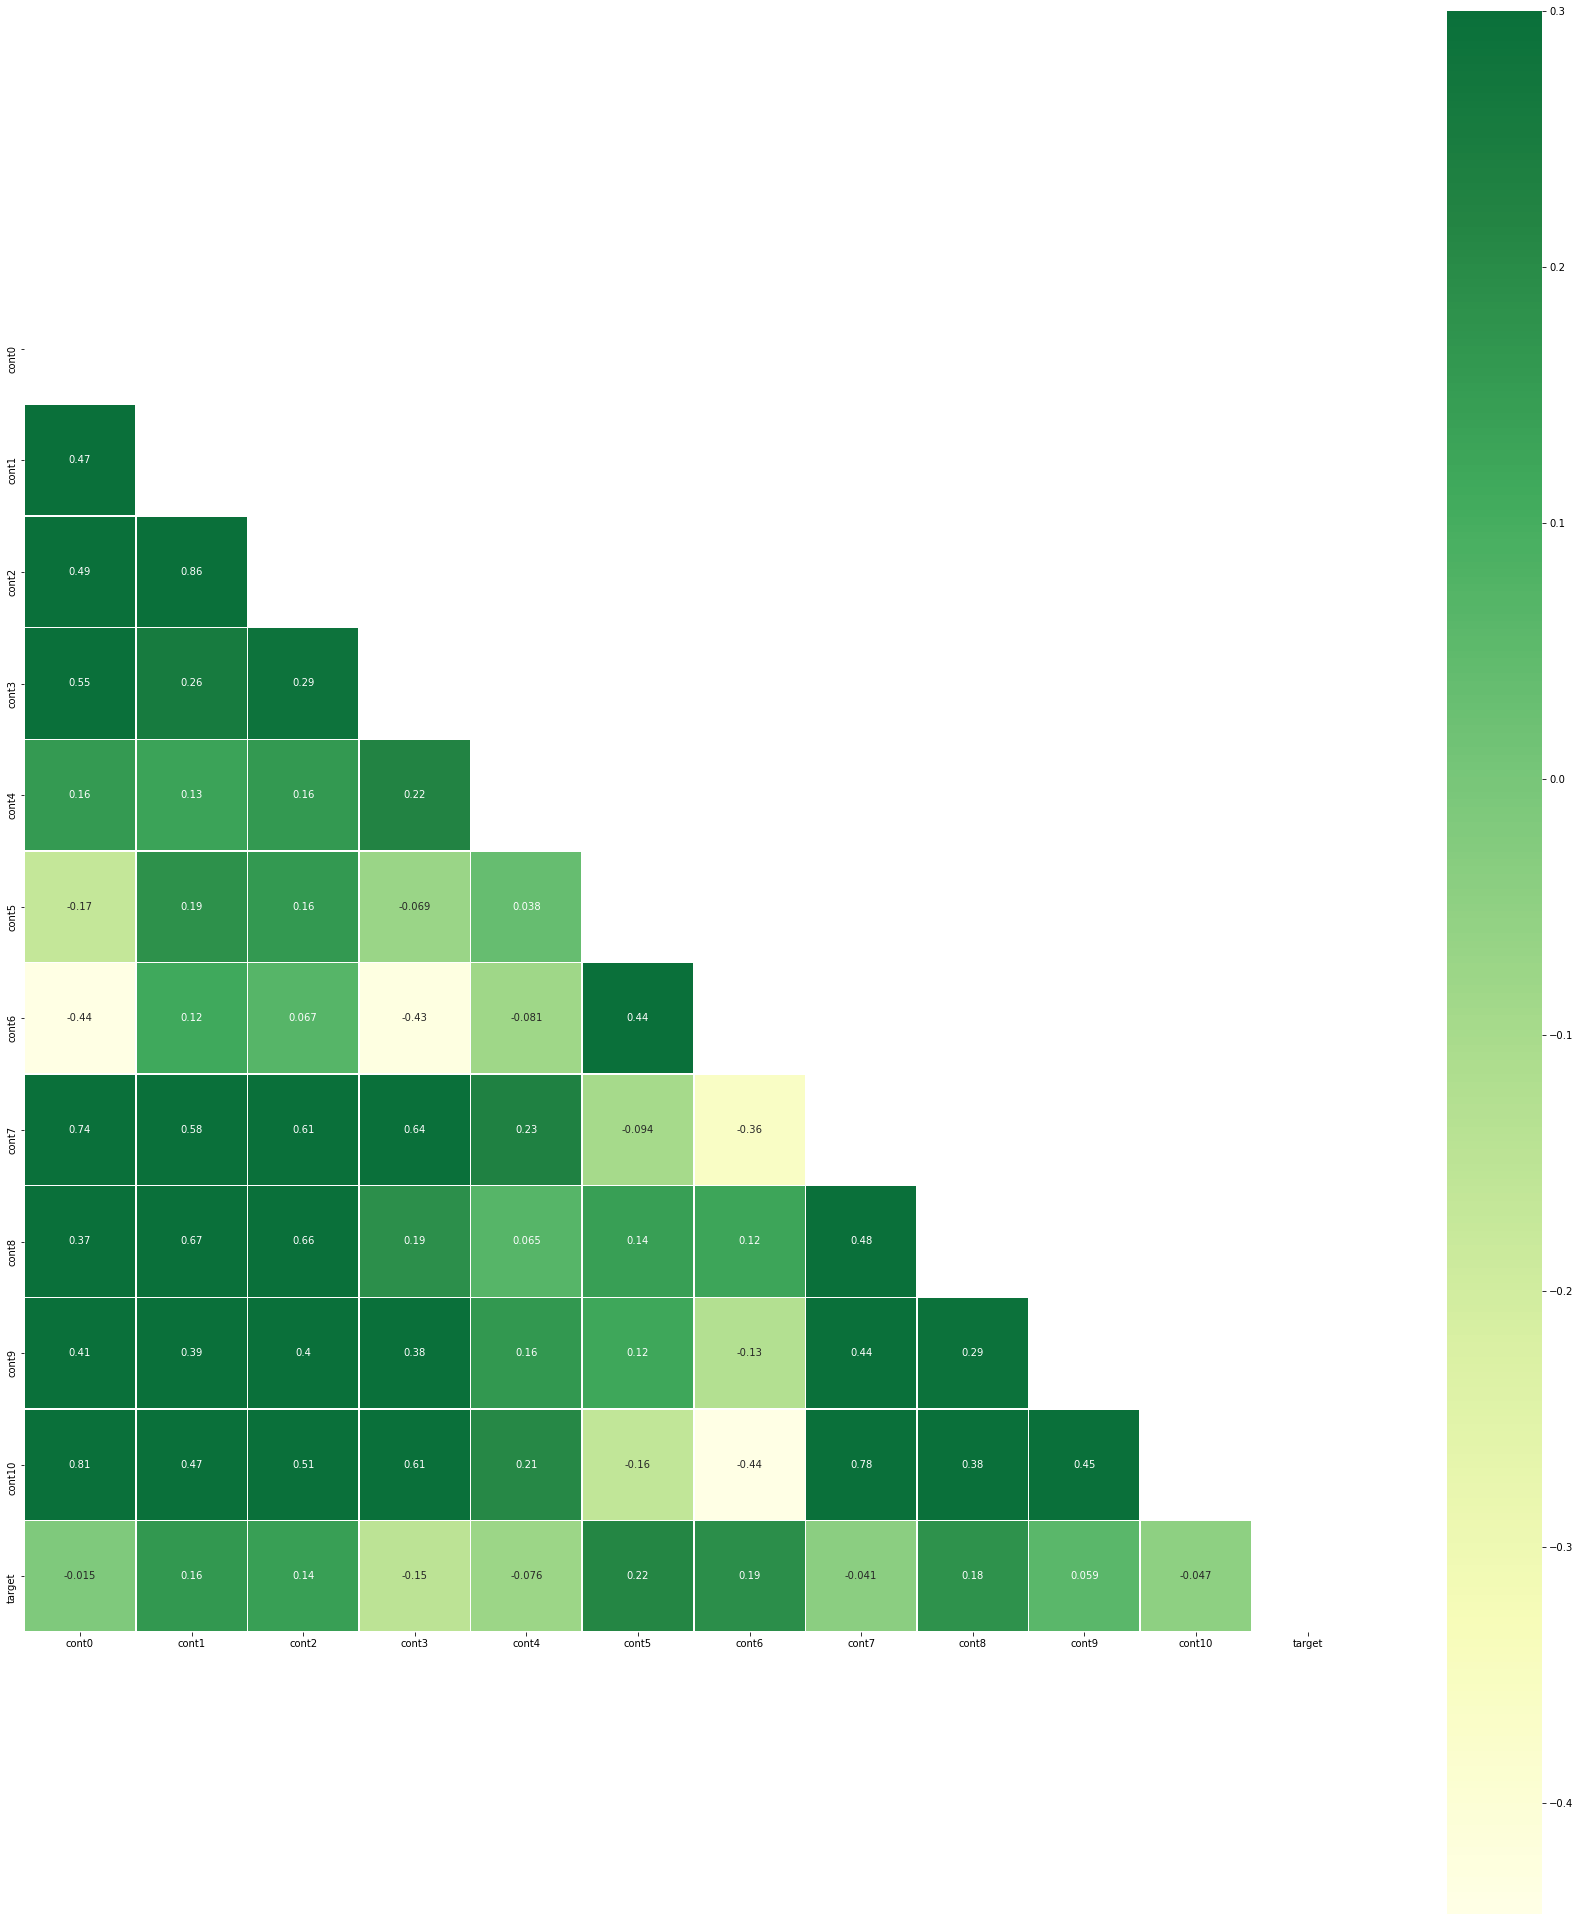

In [16]:
plt.figure(figsize=(30,35))
corr=train_p.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='YlGn', vmax=.3, center=0,
            square=True, linewidths=.5,annot=True)
plt.show()

In [17]:
indices = corr.index.values
cor_matrix = np.asmatrix(corr)
G = nx.from_numpy_matrix(cor_matrix)
G = nx.relabel_nodes(G,lambda x: indices[x])
G.edges(data=True)

EdgeDataView([('cont0', 'cont0', {'weight': 1.0}), ('cont0', 'cont1', {'weight': 0.47404630090544736}), ('cont0', 'cont2', {'weight': 0.4946222271969707}), ('cont0', 'cont3', {'weight': 0.5492459256887203}), ('cont0', 'cont4', {'weight': 0.15580540002254464}), ('cont0', 'cont5', {'weight': -0.16939302390177066}), ('cont0', 'cont6', {'weight': -0.4365553821131742}), ('cont0', 'cont7', {'weight': 0.7403767466591342}), ('cont0', 'cont8', {'weight': 0.36779446587888637}), ('cont0', 'cont9', {'weight': 0.41475803602960015}), ('cont0', 'cont10', {'weight': 0.8078962099653254}), ('cont0', 'target', {'weight': -0.015172498383795972}), ('cont1', 'cont1', {'weight': 1.0}), ('cont1', 'cont2', {'weight': 0.8616228133269985}), ('cont1', 'cont3', {'weight': 0.25685367907840306}), ('cont1', 'cont4', {'weight': 0.1339882613507676}), ('cont1', 'cont5', {'weight': 0.18583845239714067}), ('cont1', 'cont6', {'weight': 0.11629591946765368}), ('cont1', 'cont7', {'weight': 0.5812007466865274}), ('cont1', 'co

In [18]:
def corr_network(G, corr_direction, min_correlation):
    H = G.copy()

    for s1, s2, weight in G.edges(data=True):       
        if corr_direction == "positive":
            if weight["weight"] < 0 or weight["weight"] < min_correlation:
                H.remove_edge(s1, s2)
        else:
            if weight["weight"] >= 0 or weight["weight"] > min_correlation:
                H.remove_edge(s1, s2)
                
    edges,weights = zip(*nx.get_edge_attributes(H,'weight').items())
    
    weights = tuple([(1+abs(x))**2 for x in weights])
   
    d = dict(nx.degree(H))
    nodelist=d.keys()
    node_sizes=d.values()
    
    positions=nx.circular_layout(H)
    
    plt.figure(figsize=(15,15))

    nx.draw_networkx_nodes(H,positions,node_color='#d100d1',nodelist=nodelist,
                       node_size=tuple([x**3 for x in node_sizes]),alpha=0.8)

    nx.draw_networkx_labels(H, positions, font_size=8)

    if corr_direction == "positive":
        edge_colour = plt.cm.cool 
    else:
        edge_colour = plt.cm.Wistia
        
    nx.draw_networkx_edges(H, positions, edgelist=edges,style='solid',
                          width=weights, edge_color = weights, edge_cmap = edge_colour,
                          edge_vmin = min(weights), edge_vmax=max(weights))
    plt.axis('off')
    plt.show() 

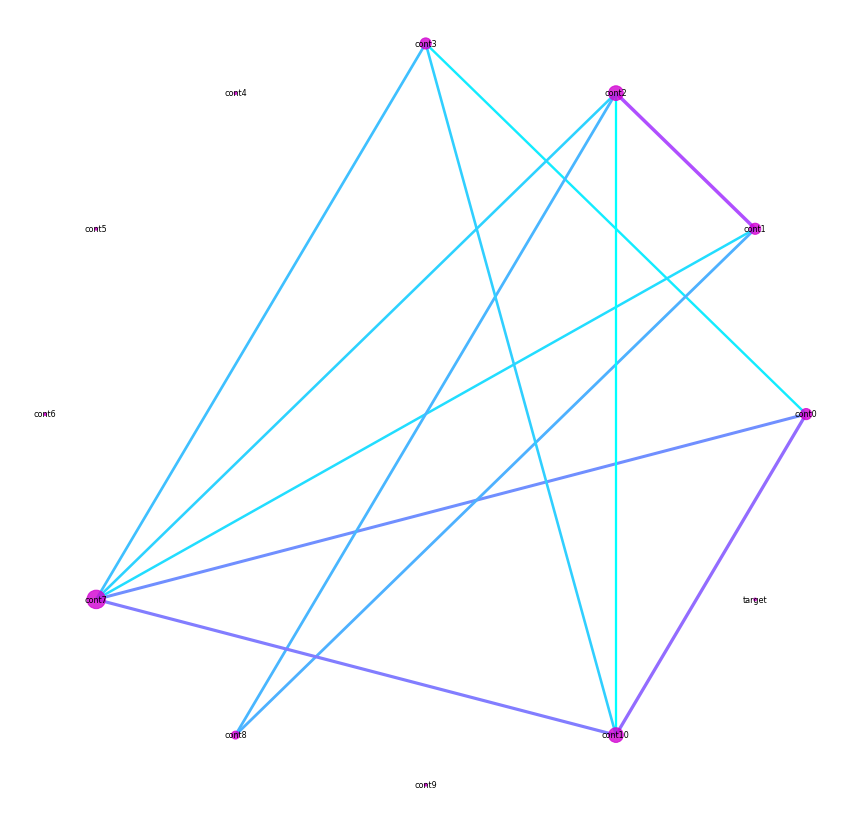

In [19]:
corr_network(G, corr_direction="positive",min_correlation = 0.5)

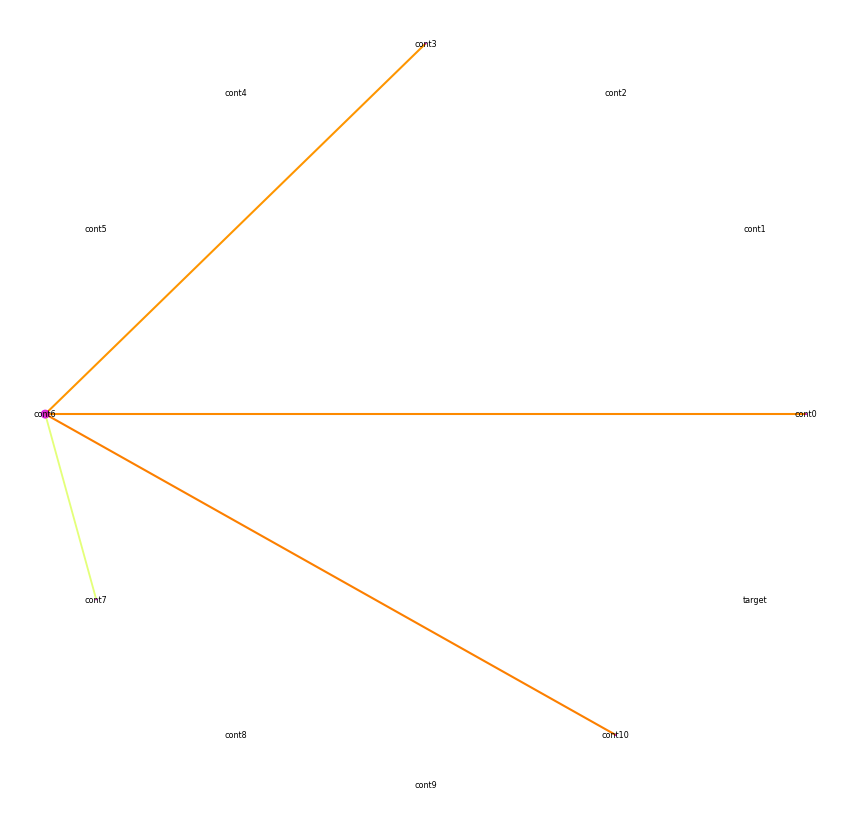

In [20]:
corr_network(G, corr_direction="negative",min_correlation = -0.3)

# 3. Target Encoding 🎯

In [21]:
%%time
SMOOTH = 0.001
SPLIT = 'interleaved'
FOLDS = 5

encoder = TargetEncoder(n_folds=FOLDS, smooth=SMOOTH, split_method=SPLIT)

CPU times: user 21 µs, sys: 3 µs, total: 24 µs
Wall time: 28.1 µs


In [22]:
%%time

X = train_df.drop(["target"],axis=1)
y = train_df["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    shuffle=False, stratify=y)
for col in train_df.columns:
    if train_df[col].dtype=='object': 
        X_train[col] = encoder.fit_transform(X_train[col],y_train)
        X_test[col] = encoder.transform(X_test[col])
        test_df[col] = encoder.transform(test_df[col])

CPU times: user 4.43 s, sys: 261 ms, total: 4.69 s
Wall time: 4.8 s


# 4. Model Training 🛠️

In [23]:
def training(model, X_train, y_train, X_test, y_test, model_name):
    t1 = time.time()
    
    model.fit(X_train, y_train)
    predicts = model.predict(X_test)
    roc = ras(y_test, predicts)
    
    t2 = time.time()
    training_time = t2-t1 
    
    print("\t\t\t--- Model:", model_name,"---")
    print("ROC: ", roc,"\t\t\t","Training time:",training_time,"\n")

In [24]:
ridge = Ridge(fit_intercept = True, normalize = False,solver = "eig")

svr = SVR(kernel='rbf', gamma='scale', C=1, epsilon=0.3)

knc =  KNeighborsClassifier(n_neighbors=3)

m = [ridge,svr,knc]
mn = ["Ridge","SVR","K Neighbors Classifier"]

for i in range(0,len(m)):
    training(model=m[i], X_train=X_train, y_train=y_train, X_test=X_test,y_test=y_test, model_name=mn[i])

			--- Model: Ridge ---
ROC:  0.8746745586395264 			 Training time: 11.659762144088745 

			--- Model: SVR ---
ROC:  0.8360768556594849 			 Training time: 74.27752375602722 

			--- Model: K Neighbors Classifier ---
ROC:  0.7449390888214111 			 Training time: 5.036773920059204 



In [25]:
dtrain = xgboost.DMatrix(X_train,y_train)
dval   = xgboost.DMatrix(X_test, y_test)
dtest  = xgboost.DMatrix(test_df)

params1 = { 'objective': 'binary:logistic',
    'booster': 'gbtree',
    'tree_method': 'gpu_hist',
    'eval_metric': 'auc',
    'random_state': 42,
    'max_depth': 15,
    'learning_rate': 0.03,
    'min_child_weight': 20,
    'gamma': 0.1,
    'alpha': 0.2,
    'lambda': 9,
    'colsample_bytree': 0.2,
    'subsample': 0.8}

evallist = [(dval, 'validation'), (dtrain, 'train')]
num_round=50

In [26]:
%%time

xgb = xgboost.train(params1, dtrain,num_round,evallist)

predicts = xgb.predict(xgboost.DMatrix(X_test))
roc = ras(y_test, predicts)
roc

[0]	validation-auc:0.82896	train-auc:0.83122
[1]	validation-auc:0.84625	train-auc:0.84999
[2]	validation-auc:0.85926	train-auc:0.86395
[3]	validation-auc:0.86457	train-auc:0.86979
[4]	validation-auc:0.86664	train-auc:0.87215
[5]	validation-auc:0.87192	train-auc:0.87722
[6]	validation-auc:0.87316	train-auc:0.87874
[7]	validation-auc:0.87383	train-auc:0.88016
[8]	validation-auc:0.87371	train-auc:0.88013
[9]	validation-auc:0.87363	train-auc:0.88030
[10]	validation-auc:0.87321	train-auc:0.87981
[11]	validation-auc:0.87417	train-auc:0.88088
[12]	validation-auc:0.87428	train-auc:0.88090
[13]	validation-auc:0.87587	train-auc:0.88265
[14]	validation-auc:0.87780	train-auc:0.88440
[15]	validation-auc:0.87864	train-auc:0.88553
[16]	validation-auc:0.87823	train-auc:0.88536
[17]	validation-auc:0.87862	train-auc:0.88597
[18]	validation-auc:0.87868	train-auc:0.88633
[19]	validation-auc:0.87893	train-auc:0.88679
[20]	validation-auc:0.87932	train-auc:0.88724
[21]	validation-auc:0.87982	train-auc:0.8877

0.885077178478241

In [27]:
preds1 = xgb.predict(xgboost.DMatrix(test_df))

ids = cudf.read_csv('../input/tabular-playground-series-mar-2021/sample_submission.csv')[["id"]].values

# 5. Feature Importance 📎

In [28]:
def feature_imp(model):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test.to_pandas())
    shap.summary_plot(shap_values, X_test.to_pandas(), plot_type="bar",color='#7bf1a8')

    shap.summary_plot(shap_values, X_test.to_pandas())

    shap.dependence_plot("cat16", shap_values, X_test.to_pandas())

    shap.dependence_plot("cat15", shap_values, X_test.to_pandas())

    shap.dependence_plot("cat1", shap_values, X_test.to_pandas())

    shap.dependence_plot("cat14", shap_values, X_test.to_pandas())

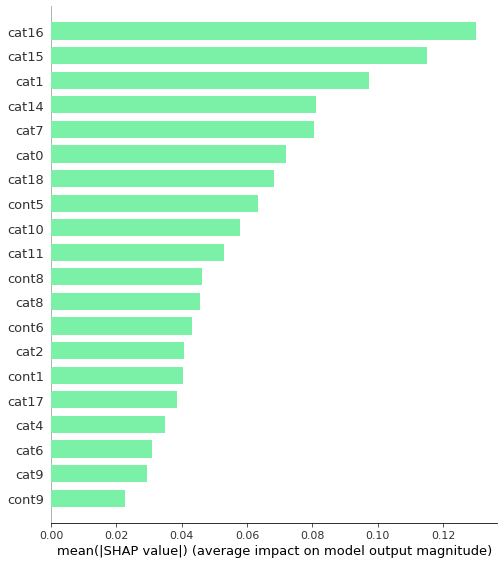

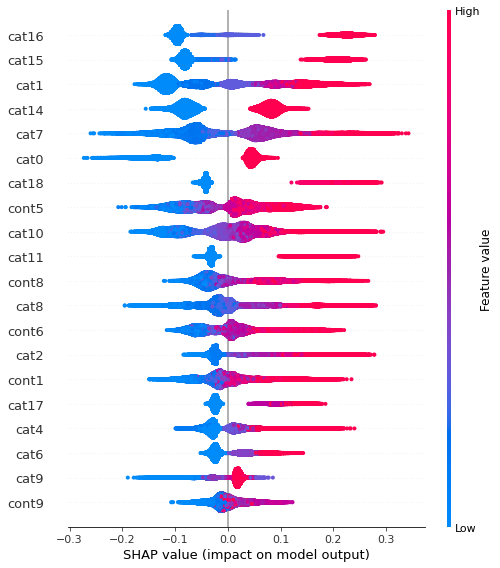

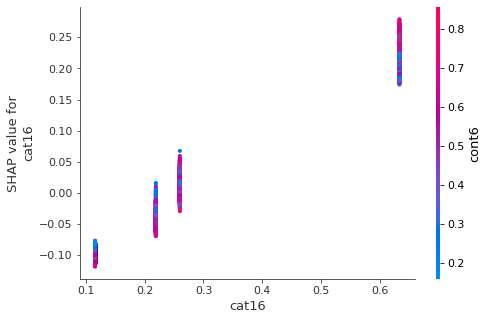

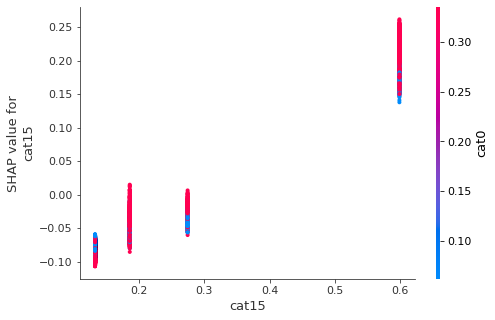

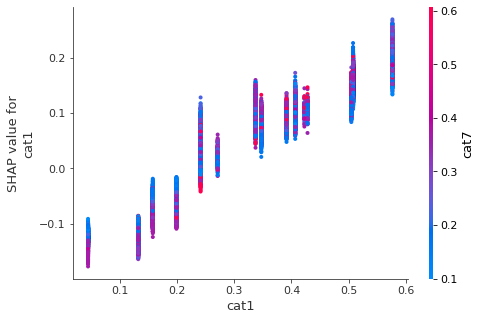

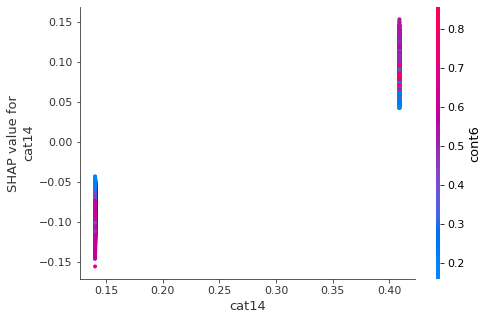

CPU times: user 28 s, sys: 177 ms, total: 28.2 s
Wall time: 28.3 s


In [29]:
%%time
feature_imp(xgb)

# 6. Creating the submission file 📋

In [30]:
df_sub = {'id': ids, 'target': preds1}
df_predictions = cudf.DataFrame(df_sub).set_index(['id'])
df_predictions.head(10)

,target
id,
5,0.241036
6,0.397113
8,0.192261
9,0.240254
11,0.241330
15,0.349445
16,0.226367
17,0.249865
21,0.260586


In [31]:
df_predictions.to_csv('/kaggle/working/Predictions.csv')

References📜

* [NetworkX documentation](https://networkx.org/documentation/stable/tutorial.html)
* [Visualising stocks correlations with Networkx](https://towardsdatascience.com/visualising-stocks-correlations-with-networkx-88f2ee25362e)

Illustrations tools ⚡
- [Canva](https://www.canva.com/en_gb/) 🖌️
- [Storyset](https://storyset.com/) 🖼️

<div>
    <img src="https://i.imgur.com/pl3FhXV.png">
 </div>